In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


#  Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
import s3fs

In [2]:
#val test Generation
def image_dataset_generator(uri, batch=16, shuffle=True, repeat=True):
    
    file_gen = fs.walk(uri) # would become self.fs
    classes = next(file_gen)[1]
    one_hot_encoder = dict(zip(classes, np.eye(len(classes))))
    dataset = [('s3://' + c[0] + '/' + f, one_hot_encoder[c[0].split('/')[-1]]) for c in file_gen for f in c[2]]

    if shuffle:
        np.random.shuffle(dataset)

    i = 0

    while True:

        if i == len(dataset):
            if repeat:
                i = 0
            else:
                continue # TODO(developer): frankly not sure what to do here, need to test out

        images, labels = [], []

        for sample in range(batch):
            path, label = dataset[i]

            with fs.open(path) as f:
                img = f.read()
                img = tf.io.decode_image(img)
                img = tf.image.convert_image_dtype(img, tf.float32)
                images.append(img)

            label = tf.convert_to_tensor(label)
            labels.append(label)

            i += 1
        # [None] overrides a silly error from TF 2.1:
        # https://stackoverflow.com/questions/59317919/warningtensorflowsample-weight-modes-were-coerced-from-to
        yield tf.convert_to_tensor(images), tf.convert_to_tensor(labels), [None] 


In [3]:
fs = s3fs.S3FileSystem()

In [4]:
# here we play pretend, instead this would be train and val
batch = 16 # will be handled by wandb
train_ds = image_dataset_generator('s3://ssa-data/dataset/source/training', )
val_ds = image_dataset_generator('s3://ssa-data/dataset/source/validation')
classes = [d['Key'].split('/')[-1] for d in fs.listdir('s3://ssa-data/dataset/source/training') if d['StorageClass']=='DIRECTORY']
num_train = sum([len(fs.ls(f's3://ssa-data/dataset/source/training/{c}')) for c in classes])
num_val = sum([len(fs.ls(f's3://ssa-data/dataset/source/training{c}')) for c in classes])
train_steps = int(np.ceil(num_train/batch))
val_steps = int(np.ceil(num_val/batch))

In [5]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(batch):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        plt.title(tf.boolean_mask(classes, label_batch[n])[0].numpy().decode())
        plt.axis('off')

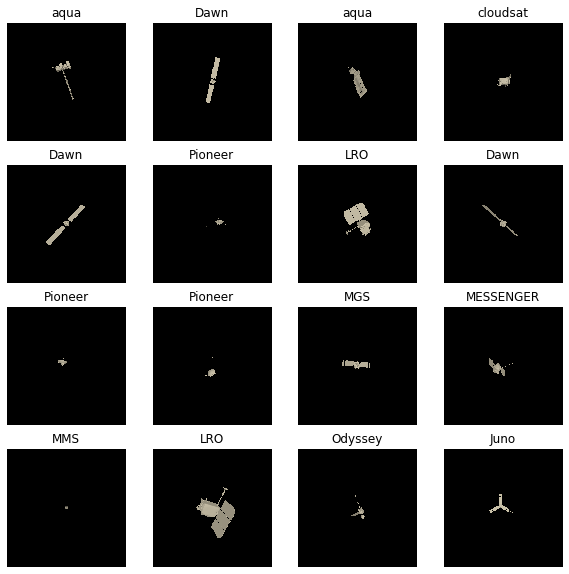

In [6]:
tr_image_batch, tr_label_batch, _ = next(train_ds)
show_batch(tr_image_batch.numpy(), tr_label_batch.numpy())

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


In [ ]:
p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10
                                                             

In [6]:
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));

NameError: name 'p_test' is not defined

## Demo the Final Model
NOTE: best_model_path needs to be assigned programatically, val_ds generator being used here

### Prediction Demo

In [13]:
def prediction_demo(model, image_batch, label_batch):
    
    predictions = model.predict(image_batch, verbose=1)

    plt.figure(figsize=(10,10))
    
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        plt.imshow(image_batch[n])
        plt.title('Truth: ' + tf.boolean_mask(classes, label_batch[n])[0].numpy().decode() +
                  '\nPrediction: ' + classes[np.argmax(predictions[n])] +
                  '\nConfidence: ' + str(round(np.max(predictions[n]*100),1)) + '%'
                 )

        plt.axis('off')

    plt.subplots_adjust(top=1.2, right = 1.0)

### Display Demo

In [14]:
demo_image_batch, demo_label_batch, _ = next(iter(val_ds))

16/16 [==============================] - 6s 381ms/sample


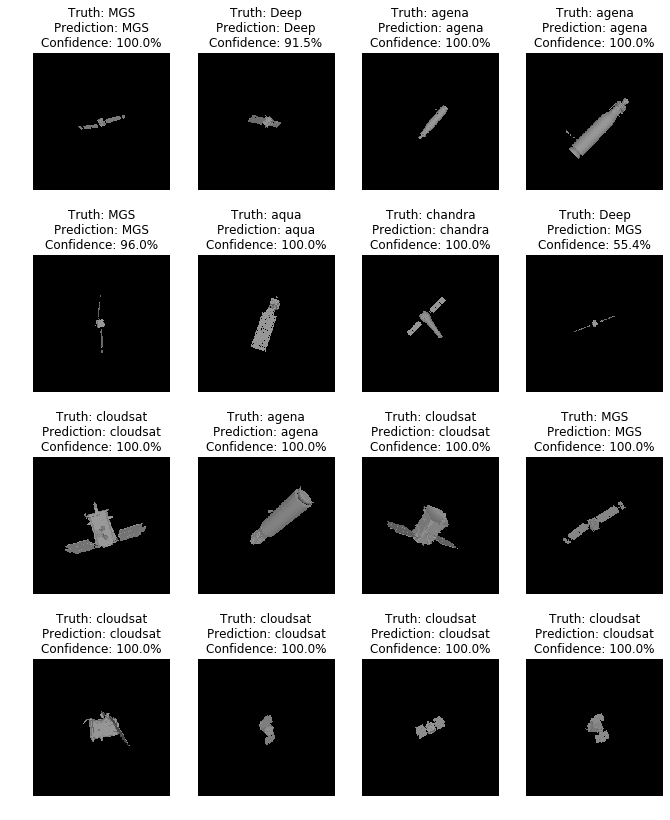

In [15]:
prediction_demo(best_model, demo_image_batch, demo_label_batch)